## Load data

In [3]:
import pandas as pd
import zarr


labels_path = '/home/ec2-user/cytoself-data/labels.csv'
sequences_path = '/home/ec2-user/cytoself-data/ESM_sequence_embeddings_full.zarr'

labels = pd.read_csv(labels_path, index_col=0)
labels = labels.fillna('')

sequences = zarr.open(sequences_path, 'r')

/tmp/ipykernel_1763/2522181359.py:8: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv(labels_path, index_col=0)


In [4]:
labels = labels.drop_duplicates('ensg')
labels['localization'] = labels['localization'].replace('', 'other')
labels = labels[labels['localization'] != 'other']

In [5]:
labels_train = labels[labels["split_protein"] == 'train']
labels_val = labels[labels["split_protein"] == 'val']

In [6]:
labels_train

,index,ensg,name,loc_grade1,loc_grade2,loc_grade3,protein_id,FOV_id,split_protein,split_images,label,Peptide,Protein stable ID,seq_embedding_index,truncation,localization,complex,complex_fig
11668,11668,ENSG00000007923,DNAJC11,mitochondria,,,22,6468,train,train,10,MATALSEEELDNEDYYSLLNVRREASSEELKAAYRRLCMLYHPDKH...,ENSP00000366800,11,559,mitochondria,,
13483,13483,ENSG00000104129,DNAJC17,nucleoplasm,,,26,6539,train,train,11,MAVTKELLQMDLYALLGIEEKAADKEVKKAYRQKALSCHPDKNPDN...,ENSP00000220496,13,304,nucleoplasm,,
14453,14453,ENSG00000170464,DNAJC18,er,,big_aggregates,27,6555,train,train,12,MAATLGSGERWTEAYIDAVRRNKYPEDTPPESHDPCGCCNCMKAQK...,ENSP00000302843,14,358,ER,,
15717,15717,ENSG00000105821,DNAJC2,cytoplasmic,,,28,6574,train,train,13,MLLLPSAADGRGTAITHALTSASTLCQVEPVGRWFEAFVKRRNRNA...,ENSP00000368565,15,621,cytoplasm,,
19616,19616,ENSG00000285317,DNAJC8,nucleoplasm,,,37,6744,train,test,16,MAASGESGTSGGGGSTEEAFMTFYSEVKQIEKRDSVLTSKNQIERL...,ENSP00000494062,19,253,nucleoplasm,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123435,59360,ENSG00000173020,GRK2,cytoplasmic,,,1921,36569,train,train,1034,MADLEAVLADVSYLMAMEKSKATPAARASKKILLPEPSIRSVMQKY...,ENSP00000312262,1290,689,cytoplasm,,
1124558,60483,ENSG00000100124,ANKRD54,nucleoplasm,nuclear_punctae,,1926,36601,train,train,1036,MAAAAGDADDEPRSGHSSSEGECAVAPEPLTDAEGLFSFADFGSAL...,ENSP00000215941,1293,300,nucleoplasm,,
1126978,62903,ENSG00000197321,SVIL,membrane,vesicles,,1935,36920,train,train,1041,MKRKERIARRLEGIENDTQPILLQSCTGLVTHRLLEEDTPRYMRAS...,ENSP00000348128,1300,1024,vesicles,,
1127350,63275,ENSG00000161671,EMC10,er,,,1936,37557,train,train,1042,MAAASAGATRLLLLLLMAVAAPSRARGSGCRAGTGARGAGAEGREG...,ENSP00000334037,1301,262,ER,,


In [14]:
def get_query(labels, idx):
    row = labels.iloc[idx]
    
    return ({
        'ensg': row['ensg'],
        'name': row['name'],
    }, {
        'ensg': row['ensg'],
        'name': row['name'],
        'localization': row['localization'],
    })

In [15]:
get_query(labels_train, 10)

({'ensg': 'ENSG00000139514', 'name': 'SLC7A1'},
 {'ensg': 'ENSG00000139514', 'name': 'SLC7A1', 'localization': 'vesicles'})

In [ ]:
SYSTEM_PROMPT = """
    You are an AI assistant to a cell biologist tasked with converting from common names of proteins to Ensmbl IDs.


    You will be provided with the common name in JSON and return the common name and Ensmbl ID. Do not return any additional text.

    For example

    {'name': 'DNAJC11'}

    returns

    {'name': 'DNAJC11',
    'ensg': 'ENSG00000007923'}

    and

    {'name': 'DNAJC18'}

    returns

    {'name': 'DNAJC18',
    'ensg': 'ENSG00000170464'}
"""

In [17]:
examples = [get_query(labels_train, i) for i in range(10)]

In [187]:
base_prompt = """
You are an AI assistant to a cell biologist tasked with predicting the subcellular localization of proteins in HEK293T cells.

The available locations you are to pick from are ['mitochondria', 'nucleoplasm', 'ER', 'cytoplasm', 'vesicles', 'nuclear_membrane', 'nucleolus', 'Golgi', 'nuclear_domains'].

You will only be asked about proteins that have a single localization and you should return only that localization.

You will be provided with a list of the Ensmbl ID and the common name of the protein in JSON format and return a list of the Ensmbl ID, common name, and the location also in JSON format.

Please return answers for all the entries in the list. Please do not return any additional text.
"""


example_promt = "\nFor example: \n\n" + "\n".join([f"{e[0]}" for e in examples]) + "\n\nReturns\n\n" + "\n".join([f"{e[1]}" for e in examples])
close_prompt = '\n\nUnderstood?'

system_prompt = base_prompt + example_promt + close_prompt

In [188]:
print(system_prompt)


You are an AI assistant to a cell biologist tasked with predicting the subcellular localization of proteins in HEK293T cells.

The available locations you are to pick from are ['mitochondria', 'nucleoplasm', 'ER', 'cytoplasm', 'vesicles', 'nuclear_membrane', 'nucleolus', 'Golgi', 'nuclear_domains'].

You will only be asked about proteins that have a single localization and you should return only that localization.

You will be provided with a list of the Ensmbl ID and the common name of the protein in JSON format and return a list of the Ensmbl ID, common name, and the location also in JSON format.

Please return answers for all the entries in the list. Please do not return any additional text.

For example: 

{'ensg': 'ENSG00000117758', 'name': 'STX12'}
{'ensg': 'ENSG00000213585', 'name': 'VDAC1'}
{'ensg': 'ENSG00000165637', 'name': 'VDAC2'}
{'ensg': 'ENSG00000078668', 'name': 'VDAC3'}
{'ensg': 'ENSG00000163002', 'name': 'NUP35'}
{'ensg': 'ENSG00000170540', 'name': 'ARL6IP1'}
{'ensg'

In [248]:
# test = [get_query(labels_train, i) for i in range(11, 301)]
test = [get_query(labels_val, i) for i in range(0, 45)]

In [249]:
inputs = [r[0] for r in test]
outputs = [r[1] for r in test]

In [250]:
inputs

[{'ensg': 'ENSG00000244038', 'name': 'DDOST'},
 {'ensg': 'ENSG00000228474', 'name': 'OST4'},
 {'ensg': 'ENSG00000124641', 'name': 'MED20'},
 {'ensg': 'ENSG00000148297', 'name': 'MED22'},
 {'ensg': 'ENSG00000163624', 'name': 'CDS1'},
 {'ensg': 'ENSG00000162298', 'name': 'SYVN1'},
 {'ensg': 'ENSG00000010278', 'name': 'CD9'},
 {'ensg': 'ENSG00000100949', 'name': 'RABGGTA'},
 {'ensg': 'ENSG00000288401', 'name': 'CTTN'},
 {'ensg': 'ENSG00000106976', 'name': 'DNM1'},
 {'ensg': 'ENSG00000100266', 'name': 'PACSIN2'},
 {'ensg': 'ENSG00000152767', 'name': 'FARP1'},
 {'ensg': 'ENSG00000017797', 'name': 'RALBP1'},
 {'ensg': 'ENSG00000170776', 'name': 'AKAP13'},
 {'ensg': 'ENSG00000157985', 'name': 'AGAP1'},
 {'ensg': 'ENSG00000177951', 'name': 'BET1L'},
 {'ensg': 'ENSG00000136738', 'name': 'STAM'},
 {'ensg': 'ENSG00000162607', 'name': 'USP1'},
 {'ensg': 'ENSG00000068654', 'name': 'POLR1A'},
 {'ensg': 'ENSG00000005893', 'name': 'LAMP2'},
 {'ensg': 'ENSG00000042088', 'name': 'TDP1'},
 {'ensg': 'ENSG

In [178]:
gpt4_results = [
{'ensg': 'ENSG00000117758', 'name': 'STX12', 'localization': 'vesicles'},
{'ensg': 'ENSG00000213585', 'name': 'VDAC1', 'localization': 'mitochondria'},
{'ensg': 'ENSG00000165637', 'name': 'VDAC2', 'localization': 'mitochondria'},
{'ensg': 'ENSG00000078668', 'name': 'VDAC3', 'localization': 'mitochondria'},
{'ensg': 'ENSG00000163002', 'name': 'NUP35', 'localization': 'nuclear_membrane'},
{'ensg': 'ENSG00000170540', 'name': 'ARL6IP1', 'localization': 'ER'},
{'ensg': 'ENSG00000131467', 'name': 'PSME3', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000100519', 'name': 'PSMC6', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000131470', 'name': 'PSMC3IP', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000283777', 'name': 'CANX', 'localization': 'ER'},
{'ensg': 'ENSG00000165782', 'name': 'PIP4P1', 'localization': 'vesicles'},
{'ensg': 'ENSG00000155252', 'name': 'PI4K2A', 'localization': 'vesicles'},
{'ensg': 'ENSG00000115020', 'name': 'PIKFYVE', 'localization': 'vesicles'},
{'ensg': 'ENSG00000198856', 'name': 'OSTC', 'localization': 'ER'},
{'ensg': 'ENSG00000163463', 'name': 'KRTCAP2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000134910', 'name': 'STT3A', 'localization': 'ER'},
{'ensg': 'ENSG00000163527', 'name': 'STT3B', 'localization': 'ER'},
{'ensg': 'ENSG00000163902', 'name': 'RPN1', 'localization': 'ER'},
{'ensg': 'ENSG00000118705', 'name': 'RPN2', 'localization': 'ER'},
{'ensg': 'ENSG00000129562', 'name': 'DAD1', 'localization': 'ER'},
{'ensg': 'ENSG00000152944', 'name': 'MED21', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000133398', 'name': 'MED10', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000133997', 'name': 'MED6', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000159479', 'name': 'MED8', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000042429', 'name': 'MED17', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000130772', 'name': 'MED18', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000118579', 'name': 'MED28', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000099917', 'name': 'MED15', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000180182', 'name': 'MED14', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000108590', 'name': 'MED31', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000156603', 'name': 'MED19', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000136146', 'name': 'MED4', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000161920', 'name': 'MED11', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000160563', 'name': 'MED27', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000141026', 'name': 'MED9', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000063322', 'name': 'MED29', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000101997', 'name': 'CCDC22', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000125633', 'name': 'CCDC93', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000099901', 'name': 'RANBP1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000001630', 'name': 'CYP51A1', 'localization': 'ER'},
{'ensg': 'ENSG00000100596', 'name': 'SPTLC2', 'localization': 'ER'},
{'ensg': 'ENSG00000012660', 'name': 'ELOVL5', 'localization': 'ER'},
{'ensg': 'ENSG00000138678', 'name': 'GPAT3', 'localization': 'ER'},
{'ensg': 'ENSG00000278322', 'name': 'MBOAT7', 'localization': 'ER'},
{'ensg': 'ENSG00000156471', 'name': 'PTDSS1', 'localization': 'ER'},
{'ensg': 'ENSG00000174915', 'name': 'PTDSS2', 'localization': 'ER'},
{'ensg': 'ENSG00000276045', 'name': 'ORAI1', 'localization': 'ER'},
{'ensg': 'ENSG00000167323', 'name': 'STIM1', 'localization': 'ER'},
{'ensg': 'ENSG00000096433', 'name': 'ITPR3', 'localization': 'ER'},
{'ensg': 'ENSG00000184743', 'name': 'ATL3', 'localization': 'ER'},
{'ensg': 'ENSG00000185825', 'name': 'BCAP31', 'localization': 'ER'},
{'ensg': 'ENSG00000141428', 'name': 'C18orf21', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000135404', 'name': 'CD63', 'localization': 'vesicles'},
{'ensg': 'ENSG00000110651', 'name': 'CD81', 'localization': 'vesicles'},
{'ensg': 'ENSG00000139641', 'name': 'ESYT1', 'localization': 'ER'},
{'ensg': 'ENSG00000112210', 'name': 'RAB23', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000075785', 'name': 'RAB7A', 'localization': 'vesicles'},
{'ensg': 'ENSG00000115310', 'name': 'RTN4', 'localization': 'ER'},
{'ensg': 'ENSG00000106803', 'name': 'SEC61B', 'localization': 'ER'},
{'ensg': 'ENSG00000167842', 'name': 'MIS12', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000133703', 'name': 'KRAS', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000134108', 'name': 'ARL8B', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000177917', 'name': 'ARL6IP6', 'localization': 'ER'},
{'ensg': 'ENSG00000136717', 'name': 'BIN1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000172725', 'name': 'CORO1B', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000136279', 'name': 'DBNL', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000063245', 'name': 'EPN1', 'localization': 'vesicles'},
{'ensg': 'ENSG00000085832', 'name': 'EPS15', 'localization': 'vesicles'},
{'ensg': 'ENSG00000187239', 'name': 'FNBP1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000071054', 'name': 'MAP4K4', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000157483', 'name': 'MYO1E', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000158092', 'name': 'NCK1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000061676', 'name': 'NCKAP1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000149269', 'name': 'PAK1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000130340', 'name': 'SNX9', 'localization': 'vesicles'},
{'ensg': 'ENSG00000112290', 'name': 'WASF1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000158195', 'name': 'WASF2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000171475', 'name': 'WIPF2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000186153', 'name': 'WWOX', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000131381', 'name': 'RBSN', 'localization': 'vesicles'},
{'ensg': 'ENSG00000107863', 'name': 'ARHGAP21', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000066933', 'name': 'MYO9A', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000196914', 'name': 'ARHGEF12', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000104880', 'name': 'ARHGEF18', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000116641', 'name': 'DOCK7', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000173848', 'name': 'NET1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000156299', 'name': 'TIAM1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000143878', 'name': 'RHOB', 'localization': 'membrane'},
{'ensg': 'ENSG00000140750', 'name': 'ARHGAP17', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000099331', 'name': 'MYO9B', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000102606', 'name': 'ARHGEF7', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000147251', 'name': 'DOCK11', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000177105', 'name': 'RHOG', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000125753', 'name': 'VASP', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000165527', 'name': 'ARF6', 'localization': 'membrane'},
{'ensg': 'ENSG00000242247', 'name': 'ARFGAP3', 'localization': 'Golgi'},
{'ensg': 'ENSG00000137942', 'name': 'FNBP1L', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000165912', 'name': 'PACSIN3', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000137478', 'name': 'FCHSD2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000175866', 'name': 'BAIAP2', 'localization': 'membrane'},
{'ensg': 'ENSG00000006453', 'name': 'BAIAP2L1', 'localization': 'membrane'},
{'ensg': 'ENSG00000147439', 'name': 'BIN3', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000141985', 'name': 'SH3GL1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000114331', 'name': 'ACAP2', 'localization': 'membrane'},
{'ensg': 'ENSG00000112335', 'name': 'SNX3', 'localization': 'vesicles'},
{'ensg': 'ENSG00000002919', 'name': 'SNX11', 'localization': 'vesicles'},
{'ensg': 'ENSG00000147164', 'name': 'SNX12', 'localization': 'vesicles'},
{'ensg': 'ENSG00000143376', 'name': 'SNX27', 'localization': 'vesicles'},
{'ensg': 'ENSG00000284832', 'name': 'POLR2A', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000168002', 'name': 'POLR2G', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000148606', 'name': 'POLR3A', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000013503', 'name': 'POLR3B', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000186141', 'name': 'POLR3C', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000168495', 'name': 'POLR3D', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000058600', 'name': 'POLR3E', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000132664', 'name': 'POLR3F', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000113356', 'name': 'POLR3G', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000121851', 'name': 'POLR3GL', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000100413', 'name': 'POLR3H', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000155438', 'name': 'NIFK', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000152661', 'name': 'GJA1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000119139', 'name': 'TJP2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000168036', 'name': 'CTNNB1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000105829', 'name': 'BET1', 'localization': 'ER'},
{'ensg': 'ENSG00000113734', 'name': 'BNIP1', 'localization': 'ER'},
{'ensg': 'ENSG00000108587', 'name': 'GOSR1', 'localization': 'Golgi'},
{'ensg': 'ENSG00000100568', 'name': 'VTI1B', 'localization': 'vesicles'},
{'ensg': 'ENSG00000168818', 'name': 'STX18', 'localization': 'ER'},
{'ensg': 'ENSG00000118640', 'name': 'VAMP8', 'localization': 'vesicles'},
{'ensg': 'ENSG00000079950', 'name': 'STX7', 'localization': 'vesicles'},
{'ensg': 'ENSG00000117533', 'name': 'VAMP4', 'localization': 'Golgi'},
{'ensg': 'ENSG00000131165', 'name': 'CHMP1A', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000167110', 'name': 'GOLGA2', 'localization': 'Golgi'},
{'ensg': 'ENSG00000060339', 'name': 'CCAR1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000144749', 'name': 'LIG1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000198162', 'name': 'MAN1A2', 'localization': 'ER'},
{'ensg': 'ENSG00000171109', 'name': 'MFN1', 'localization': 'mitochondria'},
{'ensg': 'ENSG00000173726', 'name': 'TOMM20', 'localization': 'mitochondria'},
{'ensg': 'ENSG00000154174', 'name': 'TOMM70', 'localization': 'mitochondria'},
{'ensg': 'ENSG00000148396', 'name': 'SEC16A', 'localization': 'ER'},
{'ensg': 'ENSG00000284850', 'name': 'DCP1B', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000172795', 'name': 'DCP2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000125630', 'name': 'POLR1B', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000171453', 'name': 'POLR1C', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000137054', 'name': 'POLR1E', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000105849', 'name': 'POLR1F', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000112592', 'name': 'TBP', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000120656', 'name': 'TAF12', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000105202', 'name': 'FBL', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000055044', 'name': 'NOP58', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000107833', 'name': 'NPM3', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000121058', 'name': 'COIL', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000147533', 'name': 'GOLGA7', 'localization': 'Golgi'},
{'ensg': 'ENSG00000163399', 'name': 'ATP1A1', 'localization': 'vesicles'},
{'ensg': 'ENSG00000177697', 'name': 'CD151', 'localization': 'vesicles'},
{'ensg': 'ENSG00000140443', 'name': 'IGF1R', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000072274', 'name': 'TFRC', 'localization': 'vesicles'},
{'ensg': 'ENSG00000185896', 'name': 'LAMP1', 'localization': 'vesicles'},
{'ensg': 'ENSG00000160789', 'name': 'LMNA', 'localization': 'nuclear_membrane'},
{'ensg': 'ENSG00000113368', 'name': 'LMNB1', 'localization': 'nuclear_membrane'},
{'ensg': 'ENSG00000100372', 'name': 'SLC25A17', 'localization': 'mitochondria'},
{'ensg': 'ENSG00000132382', 'name': 'MYBBP1A', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000184432', 'name': 'COPB2', 'localization': 'ER'},
{'ensg': 'ENSG00000074695', 'name': 'LMAN1', 'localization': 'ER'},
{'ensg': 'ENSG00000115163', 'name': 'CENPA', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000120948', 'name': 'TARDBP', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000096060', 'name': 'FKBP5', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000111605', 'name': 'CPSF6', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000111641', 'name': 'NOP2', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000119523', 'name': 'ALG2', 'localization': 'ER'},
{'ensg': 'ENSG00000131016', 'name': 'AKAP12', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000136819', 'name': 'C9orf78', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000084676', 'name': 'NCOA1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000105193', 'name': 'RPS16', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000084774', 'name': 'CAD', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000053372', 'name': 'MRTO4', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000121390', 'name': 'PSPC1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000116586', 'name': 'LAMTOR2', 'localization': 'vesicles'},
{'ensg': 'ENSG00000172292', 'name': 'CERS6', 'localization': 'ER'},
{'ensg': 'ENSG00000122484', 'name': 'RPAP2', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000003249', 'name': 'DBNDD1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000177733', 'name': 'HNRNPA0', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000132792', 'name': 'CTNNBL1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000145912', 'name': 'NHP2', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000138385', 'name': 'SSB', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000163938', 'name': 'GNL3', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000171490', 'name': 'RSL1D1', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000130826', 'name': 'DKC1', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000165732', 'name': 'DDX21', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000232960', 'name': 'CSNK2B', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000100138', 'name': 'SNU13', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000105373', 'name': 'NOP53', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000285301', 'name': 'BOP1', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000130935', 'name': 'NOL11', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000107937', 'name': 'GTPBP4', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000070814', 'name': 'TCOF1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000177971', 'name': 'IMP3', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000134697', 'name': 'GNL2', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000109534', 'name': 'GAR1', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000108651', 'name': 'UTP6', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000196235', 'name': 'SUPT5H', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000106344', 'name': 'RBM28', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000262788', 'name': 'UTP4', 'localization': 'nucleolus'},
{'ensg': 'ENSG00000275700', 'name': 'AATF', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000148843', 'name': 'PDCD11', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000115368', 'name': 'WDR75', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000163608', 'name': 'NEPRO', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000100883', 'name': 'SRP54', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000198917', 'name': 'SPOUT1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000055483', 'name': 'USP36', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000115761', 'name': 'NOL10', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000131732', 'name': 'ZCCHC9', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000124383', 'name': 'MPHOSPH10', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000078061', 'name': 'ARAF', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000149311', 'name': 'ATM', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000178999', 'name': 'AURKB', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000009954', 'name': 'BAZ1B', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000235307', 'name': 'BRD2', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000141867', 'name': 'BRD4', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000198752', 'name': 'CDC42BPB', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000136807', 'name': 'CDK9', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000183765', 'name': 'CHEK2', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000151292', 'name': 'CSNK1G3', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000166333', 'name': 'ILK', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000184216', 'name': 'IRAK1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000169032', 'name': 'MAP2K1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000135341', 'name': 'MAP3K7', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000092847', 'name': 'AGO1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000123908', 'name': 'AGO2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000141503', 'name': 'MINK1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000119638', 'name': 'NEK9', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000115687', 'name': 'PASK', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000140992', 'name': 'PDPK1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000105287', 'name': 'PRKD2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000253729', 'name': 'PRKDC', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000112739', 'name': 'PRPF4B', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000169398', 'name': 'PTK2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000112655', 'name': 'PTK7', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000132155', 'name': 'RAF1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000058729', 'name': 'RIOK2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000101782', 'name': 'RIOK3', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000067900', 'name': 'ROCK1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000187514', 'name': 'PTMA', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000162302', 'name': 'RPS6KA4', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000130726', 'name': 'TRIM28', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000197323', 'name': 'TRIM33', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000105053', 'name': 'VRK3', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000176105', 'name': 'YES1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000110911', 'name': 'SLC11A2', 'localization': 'vesicles'},
{'ensg': 'ENSG00000281917', 'name': 'SLC16A1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000112394', 'name': 'SLC16A10', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000147100', 'name': 'SLC16A2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000146409', 'name': 'SLC18B1', 'localization': 'vesicles'},
{'ensg': 'ENSG00000173638', 'name': 'SLC19A1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000079215', 'name': 'SLC1A3', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000105281', 'name': 'SLC1A5', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000225697', 'name': 'SLC26A6', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000136856', 'name': 'SLC2A8', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000145740', 'name': 'SLC30A5', 'localization': 'vesicles'},
{'ensg': 'ENSG00000136868', 'name': 'SLC31A1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000127526', 'name': 'SLC35E1', 'localization': 'ER'},
{'ensg': 'ENSG00000157800', 'name': 'SLC37A3', 'localization': 'ER'},
{'ensg': 'ENSG00000281500', 'name': 'SLC37A4', 'localization': 'ER'},
{'ensg': 'ENSG00000129353', 'name': 'SLC44A2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000072041', 'name': 'SLC6A15', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000103257', 'name': 'SLC7A5', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000103064', 'name': 'SLC7A6', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000076351', 'name': 'SLC46A1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000139370', 'name': 'SLC15A4', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000088448', 'name': 'ANKRD10', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000163516', 'name': 'ANKZF1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000105186', 'name': 'ANKRD27', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000079616', 'name': 'KIF22', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000131437', 'name': 'KIF3A', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000090889', 'name': 'KIF4A', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000278259', 'name': 'MYO19', 'localization': 'mitochondria'},
{'ensg': 'ENSG00000197879', 'name': 'MYO1C', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000099995', 'name': 'SF3A1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000183431', 'name': 'SF3A3', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000115524', 'name': 'SF3B1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000189091', 'name': 'SF3B3', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000077312', 'name': 'SNRPA', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000125870', 'name': 'SNRPB2', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000124562', 'name': 'SNRPC', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000125743', 'name': 'SNRPD2', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000060688', 'name': 'SNRNP40', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000182872', 'name': 'RBM10', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000122965', 'name': 'RBM19', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000119707', 'name': 'RBM25', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000188739', 'name': 'RBM34', 'localization': 'nucleoplasm'},
]

In [252]:
gpt4_results = [
{'ensg': 'ENSG00000244038', 'name': 'DDOST', 'localization': 'ER'},
{'ensg': 'ENSG00000228474', 'name': 'OST4', 'localization': 'ER'},
{'ensg': 'ENSG00000124641', 'name': 'MED20', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000148297', 'name': 'MED22', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000163624', 'name': 'CDS1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000162298', 'name': 'SYVN1', 'localization': 'ER'},
{'ensg': 'ENSG00000010278', 'name': 'CD9', 'localization': 'vesicles'},
{'ensg': 'ENSG00000100949', 'name': 'RABGGTA', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000288401', 'name': 'CTTN', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000106976', 'name': 'DNM1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000100266', 'name': 'PACSIN2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000152767', 'name': 'FARP1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000017797', 'name': 'RALBP1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000170776', 'name': 'AKAP13', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000157985', 'name': 'AGAP1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000177951', 'name': 'BET1L', 'localization': 'ER'},
{'ensg': 'ENSG00000136738', 'name': 'STAM', 'localization': 'vesicles'},
{'ensg': 'ENSG00000162607', 'name': 'USP1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000068654', 'name': 'POLR1A', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000005893', 'name': 'LAMP2', 'localization': 'vesicles'},
{'ensg': 'ENSG00000042088', 'name': 'TDP1', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000153147', 'name': 'SMARCA5', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000282947', 'name': 'HNRNPL', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000227057', 'name': 'WDR46', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000198604', 'name': 'BAZ1A', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000133112', 'name': 'TPT1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000146872', 'name': 'TLK2', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000028116', 'name': 'VRK2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000167114', 'name': 'SLC27A4', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000138074', 'name': 'SLC5A6', 'localization': 'vesicles'},
{'ensg': 'ENSG00000089057', 'name': 'SLC23A2', 'localization': 'vesicles'},
{'ensg': 'ENSG00000206560', 'name': 'ANKRD28', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000104897', 'name': 'SF3A2', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000114416', 'name': 'FXR1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000159217', 'name': 'IGF2BP1', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000175029', 'name': 'CTBP2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000106144', 'name': 'CASP2', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000110713', 'name': 'NUP98', 'localization': 'nuclear_membrane'},
{'ensg': 'ENSG00000126883', 'name': 'NUP214', 'localization': 'nuclear_membrane'},
{'ensg': 'ENSG00000111237', 'name': 'VPS29', 'localization': 'vesicles'},
{'ensg': 'ENSG00000128463', 'name': 'EMC4', 'localization': 'ER'},
{'ensg': 'ENSG00000161091', 'name': 'MFSD12', 'localization': 'cytoplasm'},
{'ensg': 'ENSG00000062716', 'name': 'VMP1', 'localization': 'ER'},
{'ensg': 'ENSG00000185085', 'name': 'INTS5', 'localization': 'nucleoplasm'},
{'ensg': 'ENSG00000139624', 'name': 'CERS5', 'localization': 'ER'},
]

In [253]:
#outputs = [get_query(labels_train, i)[1] for i in range(11, 301)]
outputs = [get_query(labels_val, i)[1] for i in range(0, 45)]

In [254]:
y_predict = [out['localization'] for out in gpt4_results]
y_test = [out['localization'] for out in outputs]

In [257]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.6888888888888889


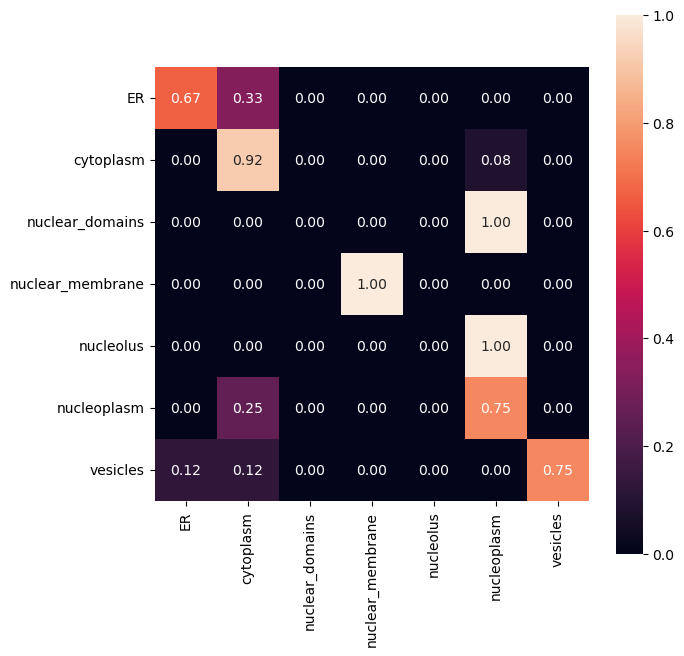

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [183]:
np.unique(y_predict)

array(['ER', 'Golgi', 'cytoplasm', 'membrane', 'mitochondria',
       'nuclear_membrane', 'nucleolus', 'nucleoplasm', 'vesicles'],
      dtype='<U16')

In [184]:
np.unique(y_test)

array(['ER', 'Golgi', 'cytoplasm', 'mitochondria', 'nuclear_domains',
       'nuclear_membrane', 'nucleolus', 'nucleoplasm', 'vesicles'],
      dtype='<U16')

In [185]:
labels_train['localization'].unique()

array(['mitochondria', 'nucleoplasm', 'ER', 'cytoplasm', 'vesicles',
       'nuclear_membrane', 'nucleolus', 'Golgi', 'nuclear_domains'],
      dtype=object)

## Using OAI API

In [2]:
import openai
import os

openai.api_key = os.environ.get('OPEN_AI_KEY')

In [238]:
len(labels_val)

45

In [239]:
test = [get_query(labels_val, i) for i in range(len(labels_val))]

In [240]:
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": base_prompt},
        {"role": "user", "content": "\n, ".join([f"{e[0]}" for e in examples])},
        {"role": "assistant", "content": "\n, ".join([f"{e[1]}" for e in examples])},
        {"role": "user", "content": "\n, ".join([f"{e[0]}" for e in test])},
    ]
)
prediction = response["choices"][0]["message"]["content"]

In [241]:
import re

y_predict = [match.group(0) for match in re.finditer(r"(?<=localization':\s')[^']+(?=\')", str(prediction.split('\n, ')))]

In [242]:
np.unique(y_predict)

array(['ER', 'Golgi', 'cytoplasm', 'lysosome', 'mitochondria',
       'nucleoplasm', 'plasma_membrane', 'vesicles'], dtype='<U15')

In [243]:
y_test = [e[1]['localization'] for e in test]

In [244]:
np.unique(y_test)

array(['ER', 'cytoplasm', 'nuclear_domains', 'nuclear_membrane',
       'nucleolus', 'nucleoplasm', 'vesicles'], dtype='<U16')

In [245]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.4888888888888889


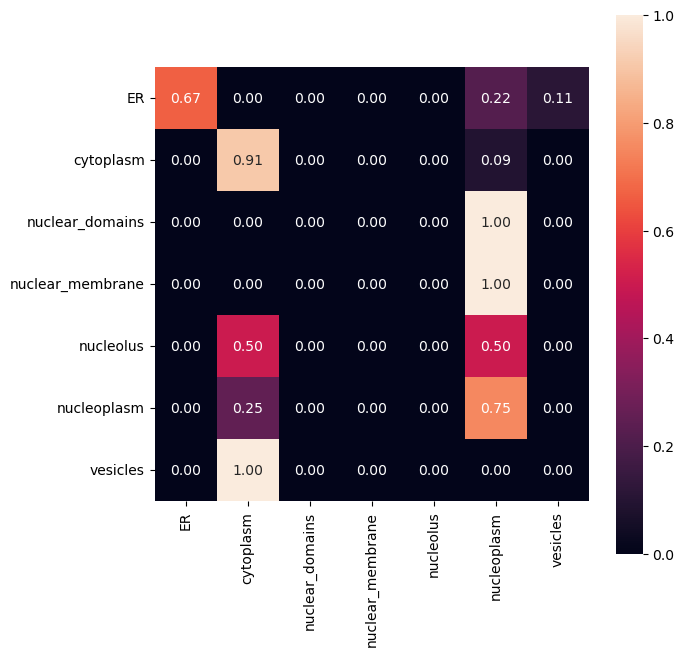

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");
